In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import javalang
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from collections import Counter
from itertools import chain

import tensorflow as tf
# import tensorflow_addons as tfa # TODO: find ready to use seq2seq modules here
from tensorflow.keras import layers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tqdm.pandas()

/home/tony/source/programming-tools/.venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


- [ ] Add a start and end token to each sentence.
- [ ] Create a token index and reverse token index (dictionaries mapping from token → id and id → token).
- [ ] Pad each sequence to a maximum length.

In [2]:
data_path = '../data/method-names-rich/elasticsearch.csv'

In [3]:
df = pd.read_csv(data_path).dropna()
df.head()

,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[]
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[]
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[]
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[]
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[]


In [4]:
def split_camel_case(str):
    words = [[str[0]]]
  
    for c in str[1:]: 
        if words[-1][-1].islower() and c.isupper(): 
            words.append(list(c)) 
        else: 
            words[-1].append(c) 
  
    return [''.join(word).lower() for word in words]

print(split_camel_case('transformSearchResponse'))
print(split_camel_case('modifySearchResponseData'))

['transform', 'search', 'response']
['modify', 'search', 'response', 'data']


In [5]:
# TODO: use a smarter identifier splitter
def get_subtokens(token):
    return split_camel_case(token)

def compute_loss(target_token, predicted_token):
    target_subtokens = get_subtokens(target_token) # a.k.a required subtokens
    predicted_subtokens = get_subtokens(predicted_token)
    overlapping = Counter(target_subtokens) & Counter(predicted_subtokens)
    overlapping_count = sum(overlapping.values())
    
    precision = 1.0 * overlapping_count / len(predicted_subtokens)
    recall = 1.0 * overlapping_count / len(target_subtokens)
    f1 = (2.0 * precision * recall) / (precision + recall)
    
    return { 'precision': precision, 'recall': recall, 'f1': f1 }

compute_loss('transformSearchResponse', 'modifySearchResponseData')

{'precision': 0.5, 'recall': 0.6666666666666666, 'f1': 0.5714285714285715}

In [6]:
# define input vocabulary

# TODO: investigate why source code body is not tokenized by javalang
invalid_body_count = 0

def tokenize_method_body(code):
    global invalid_body_count
    
    try:
        return list(map(lambda token: token.value, javalang.tokenizer.tokenize(code)))
    except Exception as e:
        invalid_body_count += 1
        if invalid_body_count % 1000 == 0:
            print(f'invalid_body_count = {invalid_body_count}')
        return []

repeating_body_tokens = pd.Series(chain.from_iterable(
    df.body \
        .progress_apply(tokenize_method_body) \
        .values
))
repeating_body_tokens

invalid_body_count = 1000
invalid_body_count = 2000
invalid_body_count = 3000
invalid_body_count = 4000
invalid_body_count = 5000
invalid_body_count = 6000
invalid_body_count = 7000
invalid_body_count = 8000
invalid_body_count = 9000
invalid_body_count = 10000
invalid_body_count = 11000
invalid_body_count = 12000



0                               {
1                          String
2                           input
3                               =
4          "\"foo\": \"\"\"bar\""
                    ...          
5695258                 remaining
5695259                         )
5695260                         ;
5695261                         }
5695262                         }
Length: 5695263, dtype: object

In [7]:
unique_body_tokens = pd.DataFrame.from_dict(Counter(repeating_body_tokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

unique_body_tokens.head(30)

,token,count
0,),762858
1,(,760010
2,.,506052
3,;,369714
4,",",298505
5,{,159308
6,},155349
7,=,120223
8,new,71574
9,return,68737


In [8]:
len(unique_body_tokens[unique_body_tokens['count'] >= 2])

66451

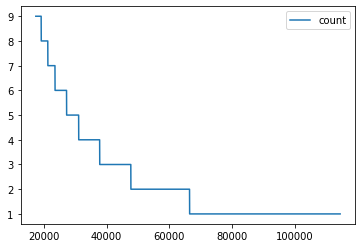

In [9]:
unique_body_tokens[unique_body_tokens['count'] < 10].plot()

In [10]:
unique_body_tokens[unique_body_tokens['count'] == 1].sample(10)

,token,count
111045,"""Number o = Integer.valueOf(0); char b = o;""",1
91845,EXPECTED_EXIT_CODES,1
82402,addPipelineMetrics,1
69709,keyMarker,1
91781,"""uFZyTyOMRO""",1
84094,"""_alias_id""",1
96389,"""fname5""",1
98752,"""def x = false; boolean y = false; return x == y""",1
86482,MISSING_TIME,1
96831,"""the_terms>the_sum""",1


[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

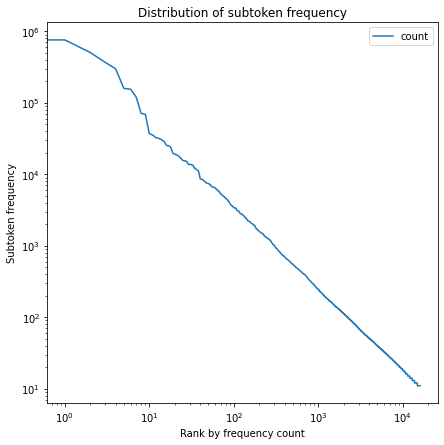

In [11]:
# index by position in the list which is sorted by frequency
ax = unique_body_tokens[unique_body_tokens['count'] > 10] \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [12]:
# # yes, the pandas groupby interface is THIS stupid :) ...
# unique_body_tokens = repeating_body_tokens \
#     .groupby(lambda index: repeating_body_tokens[index]).count()

# unique_body_tokens.head(30)

In [13]:
# define output vocabulary

repeating_method_subtokens = pd.Series(chain.from_iterable(df.method_name.progress_apply(get_subtokens).values))

# yes, the pandas groupby interface is THIS stupid :) ...
unique_method_subtokens = repeating_method_subtokens \
    .groupby(lambda index: repeating_method_subtokens[index]).count() \
    .sort_values(ascending=False)

unique_method_subtokens.head(30)

test        23812
get         14262
to           6460
set          4309
create       4088
with         3258
xcontent     3092
index        2840
field        2641
write        2493
instance     2477
name         2320
do           2317
is           2272
equals       2241
from         2230
hash         2171
code         2109
parse        2093
string       2021
query        1876
type         1747
and          1583
assert       1549
on           1520
random       1512
request      1504
value        1498
node         1418
add          1362
dtype: int64

[Text(0, 0.5, 'Subtoken frequency'),
 Text(0.5, 0, 'Rank by frequency count'),
 Text(0.5, 1.0, 'Distribution of subtoken frequency')]

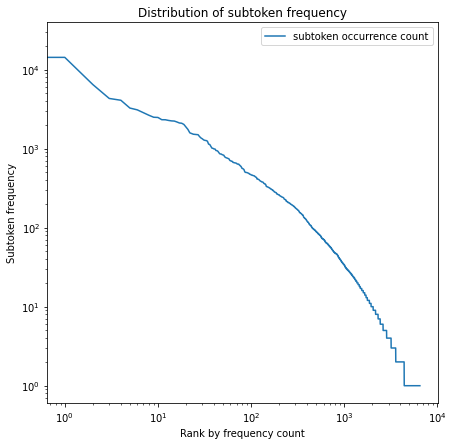

In [14]:
# index by position in the list which is sorted by frequency
ax = unique_method_subtokens \
    .sort_values(ascending=False).reset_index().rename(columns={0: 'subtoken occurrence count'}) \
    .plot(loglog=True, figsize=(7, 7))
ax.set(title='Distribution of subtoken frequency', xlabel='Rank by frequency count', ylabel='Subtoken frequency')

In [15]:
len(unique_method_subtokens)

6504

In [16]:
df_unique_method_name_subtokens = pd.DataFrame.from_dict(Counter(repeating_method_subtokens.values), orient='index') \
    .sort_values(by=0, ascending=False) \
    .reset_index().rename(columns={'index': 'token', 0: 'count'})

df_unique_method_name_subtokens.head(30)

,token,count
0,test,23812
1,get,14262
2,to,6460
3,set,4309
4,create,4088
5,with,3258
6,xcontent,3092
7,index,2840
8,field,2641
9,write,2493


In [17]:
df_unique_method_name_subtokens[df_unique_method_name_subtokens['count'] == 1].sample(10)

,token,count
6468,controls,1
5612,collection_collect,1
5913,ls,1
6380,ipv4range,1
5729,string_field,1
5899,test120docker,1
4549,brown,1
4438,field_get,1
4480,consensus,1
5793,groked,1


In [18]:
# dataset

df['body_tokens'] = df['body'].progress_apply(tokenize_method_body)

# the output sequences are marked with a <start> and <end> special tokens
df['method_name_subtokens'] = df['method_name'].progress_apply(get_subtokens)
df_clean = df[df.body_tokens.str.len() > 0] # remove invalid methods which cannot be parsed

df.head(5)

invalid_body_count = 13000
invalid_body_count = 14000
invalid_body_count = 15000
invalid_body_count = 16000
invalid_body_count = 17000
invalid_body_count = 18000
invalid_body_count = 19000
invalid_body_count = 20000
invalid_body_count = 21000
invalid_body_count = 22000
invalid_body_count = 23000
invalid_body_count = 24000



,file_name,class_name,method_name,return_type,arguments,body,documentation,modifiers,annotations,body_tokens,method_name_subtokens
0,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testInvalidBlockQuote,void,[],"{ String input = ""\""foo\"": \""\""\""bar\""""; expec...",None,['public'],[],"[{, String, input, =, ""\""foo\"": \""\""\""bar\"""", ...","[test, invalid, block, quote]"
1,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testSimpleBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort baz\"""", replac...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"""", ...","[test, simple, block, quote]"
2,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testMultipleBlockQuotes,void,[],"{ assertEquals( ""\""foo\"": \""bort baz\"", \""bar\...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort baz\"", \...","[test, multiple, block, quotes]"
3,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testEscapingInBlockQuote,void,[],"{ assertEquals(""\""foo\"": \""bort\\\"" baz\"""", re...",None,['public'],[],"[{, assertEquals, (, ""\""foo\"": \""bort\\\"" baz\...","[test, escaping, in, block, quote]"
4,data/repos/elasticsearch-master/buildSrc/src/t...,RestTestFromSnippetsTaskTests,testIsDocWriteRequest,void,[],{ assertTrue((boolean) RestTestsFromSnippetsTa...,None,['public'],[],"[{, assertTrue, (, (, boolean, ), RestTestsFro...","[test, is, doc, write, request]"



% of method_names being reduced: 0.024485720445236225


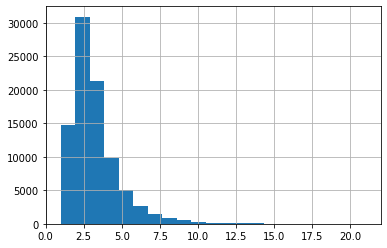

In [19]:
method_name_lengths = df_clean.method_name_subtokens.progress_apply(len)

method_name_lengths.hist(bins=method_name_lengths.max())

# we will add the <start> and <end> tokens which will effectively increase the seq length to 10 during training and prediction
max_decoder_seq_length = 8
number_of_method_names_below_threshold = len(np.where(method_name_lengths.values < max_decoder_seq_length)[0])
print(f"% of method_names being reduced: {1 - number_of_method_names_below_threshold / len(method_name_lengths)}")

In [20]:
# also cut the first max_decoder_seq_length (i.e. 8) subtokens, in order to have a fixed length
method_name_subtokens_with_start_and_end = df_clean['method_name_subtokens'] \
    .progress_apply(lambda tokens: ['<start>'] + tokens[:max_decoder_seq_length] + ['<end>'])

method_name_subtokens_with_start_and_end.progress_apply(len).describe()

count    88133.000000
mean         4.821769
std          1.576008
min          3.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: method_name_subtokens, dtype: float64

In [21]:
def get_vocabulary(series):
    all_repeating = pd.Series(chain.from_iterable(series.values))

    return pd.DataFrame.from_dict(Counter(all_repeating.values), orient='index') \
        .sort_values(by=0, ascending=False) \
        .reset_index().rename(columns={'index': 'token', 0: 'count'})

In [22]:
input_vocabulary = get_vocabulary(df_clean.body_tokens)
output_vocabulary = get_vocabulary(method_name_subtokens_with_start_and_end)
len(input_vocabulary), len(output_vocabulary)

(114536, 5809)

In [23]:
# TODO: compute what percentage of the input tokens (including repetition) will be ignored
min_input_token_count = 10
reduced_input_vocabulary = pd.Series(['<UNK>']).append(
    input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['token']
)

In [24]:
ignored_input_tokens_percentage = input_vocabulary[input_vocabulary['count'] < min_input_token_count]['count'].sum() / input_vocabulary[input_vocabulary['count'] >= min_input_token_count]['count'].sum()
print(f'reduced input vocabulary size: {len(reduced_input_vocabulary)}')
print(f'percentage of ignore input: {ignored_input_tokens_percentage}')

reduced input vocabulary size: 17373
percentage of ignore input: 0.04248435521979571


In [25]:
input_token_to_id = { token:id for id, token in enumerate(reduced_input_vocabulary) }
id_to_input_token = reduced_input_vocabulary

In [26]:
len(input_token_to_id), len(id_to_input_token)

(17373, 17373)

In [27]:
output_token_to_id = { token:id for id, token in enumerate(output_vocabulary.token) }
id_to_output_token = output_vocabulary.token

In [28]:
[(key, value) for key, value in output_token_to_id.items()][:10]

[('<start>', 0),
 ('<end>', 1),
 ('test', 2),
 ('get', 3),
 ('to', 4),
 ('set', 5),
 ('create', 6),
 ('xcontent', 7),
 ('with', 8),
 ('instance', 9)]

In [29]:
def input_tokens_to_ids(body_tokens):
    return [input_token_to_id[token] if token in input_token_to_id else 0 for token in body_tokens]

In [30]:
def output_tokens_to_ids(output_tokens):
    return [output_token_to_id[token] if token in output_token_to_id else 0 for token in output_tokens]

In [31]:
# raw hyper parameters

max_input_length = 100
max_output_length = method_name_subtokens_with_start_and_end.apply(len).max() # 10

# TODO: limit the input vocabulary size for now
input_vocab_size = 10000 # the number of method body tokens
input_embedding_dim = 50

output_vocab_size = len(output_vocabulary) # used for the softmax layer, like num_classes
output_embedding_dim = 50

latent_dim = 128 # encoder-decoder latent space dimensions

epochs = 10
batch_size=64

In [32]:
method_name_subtoken_ids = method_name_subtokens_with_start_and_end \
    .progress_apply(output_tokens_to_ids)
#     .progress_apply(lambda l: l[-max_output_length:])

method_name_subtoken_ids.progress_apply(len).describe()

count    88133.000000
mean         4.821769
std          1.576008
min          3.000000
25%          4.000000
50%          4.000000
75%          5.000000
max         10.000000
Name: method_name_subtokens, dtype: float64

In [33]:
method_name_subtokens_with_start_and_end[0], method_name_subtoken_ids[0]

(['<start>', 'test', 'invalid', 'block', 'quote', '<end>'],
 [0, 2, 99, 156, 623, 1])

In [34]:
# decoder_inputs
decoder_inputs = method_name_subtoken_ids.progress_apply(lambda seq: seq[:-1])
decoder_inputs

0                 [0, 2, 99, 156, 623]
1                [0, 2, 168, 156, 623]
2               [0, 2, 173, 156, 1846]
3           [0, 2, 1701, 50, 156, 623]
4               [0, 2, 18, 53, 12, 27]
                      ...             
100375               [0, 108, 738, 27]
100376                     [0, 33, 55]
100378             [0, 51, 1836, 1490]
100379    [0, 303, 98, 1053, 1490, 63]
100380              [0, 130, 66, 3018]
Name: method_name_subtokens, Length: 88133, dtype: object

In [35]:
# TODO:
# 1. limit output sequences to a max length
# 2. add <start> and <end> special tokens
# 3. pad the sequencecs
# 4. one hot encode the labels
padded_output_sequences = pad_sequences(
    method_name_subtoken_ids,
    maxlen=max_output_length,
    dtype='int32',
    padding='post',
    truncating='post',
    value=-1 # TODO: 0 is test and not <UNK>
)

padded_output_sequences.shape

(88133, 10)

In [36]:
len(padded_output_sequences)

88133

In [37]:
decoder_outputs = np.zeros(
    (len(padded_output_sequences), max_output_length, output_vocab_size),
    dtype='float32'
)

for seq_id, seq in enumerate(padded_output_sequences):
    for token_index, token_id in enumerate(seq):
        decoder_outputs[seq_id, token_index, token_id] = 1

decoder_outputs.shape

(88133, 10, 5809)

In [38]:
decoder_outputs[2:]

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0.

In [40]:
body_token_ids = df_clean.body_tokens.progress_apply(input_tokens_to_ids).progress_apply(lambda l: l[-max_input_length:])
body_token_ids.progress_apply(len).describe()

count    88133.000000
mean        40.473954
std         36.253899
min          2.000000
25%          9.000000
50%         24.000000
75%         74.000000
max        100.000000
Name: body_tokens, dtype: float64

In [41]:
padded_input_sequences = pad_sequences(
    body_token_ids,
    maxlen=max_input_length,
    dtype='int32',
    padding='pre',
    truncating='pre',
    value=0 # TODO: 0 should be <UNK>
)
padded_input_sequences

array([[ 0,  0,  0, ...,  1,  4,  7],
       [ 0,  0,  0, ...,  1,  4,  7],
       [ 0,  0,  0, ...,  1,  4,  7],
       ...,
       [ 8, 35,  4, ...,  7,  7,  7],
       [ 0,  0,  0, ...,  4,  7,  7],
       [ 0,  0,  0, ...,  4,  7,  7]], dtype=int32)

In [ ]:
# X_train, X_test, decoder_inputs_train, decoder_inputs_test, decoder_outputs_train, decoder_outputs_test = train_test_split(
#     padded_input_sequences,
#     decoder_inputs,
#     decoder_outputs,
#     test_size=0.2,
#     random_state=42
# )

# X_train.shape, X_test.shape, decoder_inputs_train.shape, decoder_inputs_test.shape, decoder_outputs_train.shape, decoder_outputs_test.shape

In [ ]:
df_body_length = pd.DataFrame.from_dict(Counter(df_clean.body_tokens.apply(len)), orient='index') \
    .reset_index().rename(columns={'index': 'length', 0: 'count'}) \
    .sort_values(by=['length']).set_index('length')

df_body_length.head(5)

In [ ]:
df_body_length.plot(loglog=True)

In [ ]:
print(f'number of methods with body token count less than 100: {df_body_length[df_body_length.index < 100]["count"].sum()}')

In [ ]:
df_clean.body_tokens.apply(len).describe()

In [ ]:
df_clean.method_name_subtokens.apply(len).describe()

In [ ]:
# define model: input embedding > LSTM encoder > LSTM decoder > softmax

In [ ]:
# TODO: use hyper parameters
# HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

In [47]:
def build_model():
    encoder_input = layers.Input(shape=(None, ), name='encoder_input')
    encoder_embeddeding = layers.Embedding(
        input_dim=input_vocab_size,
        output_dim=input_embedding_dim,
        name='encoder_embedding'
    )(encoder_input)

    # Return states in addition to output
    _encoder_output, state_h, state_c = layers.LSTM(
        latent_dim,
        return_state=True,
        name='encoder_lstm'
    )(encoder_embeddeding)
    
    encoder_states = [state_h, state_c]

    decoder_input = layers.Input(shape=(None, ), name='decoder_input')
    decoder_embeddeding = layers.Embedding(
        input_dim=output_vocab_size,
        output_dim=output_embedding_dim,
        name='decoder_embeddeding'
    )(decoder_input)
    
    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_outputs, _, _ = layers.LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        name='decoder_lstm'
    )(decoder_embeddeding, initial_state=encoder_states)
    
    output = layers.Dense(
        output_vocab_size,
        activation='softmax',
        name='softmax'
    )(decoder_outputs)

    model = tf.keras.Model([encoder_input, decoder_input], output)
    return model

In [48]:
model = build_model()

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 50)     500000      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_embeddeding (Embedding) (None, None, 50)     290450      decoder_input[0][0]              
____________________________________________________________________________________________

In [52]:
decoder_inputs.head()

0          [0, 2, 99, 156, 623]
1         [0, 2, 168, 156, 623]
2        [0, 2, 173, 156, 1846]
3    [0, 2, 1701, 50, 156, 623]
4        [0, 2, 18, 53, 12, 27]
Name: method_name_subtokens, dtype: object

In [49]:
history = model.fit(
    [padded_input_sequences, decoder_inputs],
    decoder_outputs,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

history

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ../logs

In [ ]:
df_train.method_name_subtokens.shape

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y)

In [ ]:
prediction = class_names[np.argmax(model.predict(test_x[0]))]
prediction

In [ ]:
encoder_input = layers.Input(shape=(None, ))
encoder_embedded = layers.Embedding(input_dim=input_vocab_size, output_dim=input_embedding_dim)(encoder_input)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(latent_dim, return_state=True, name='encoder')(encoder_embedded)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None, ))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(decoder_input)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(decoder_units, name='decoder')(decoder_embedded, initial_state=encoder_state)
output = layers.Dense(10, activation='softmax')(decoder_output)

model = tf.keras.Model([encoder_input, decoder_input], output)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

model.summary()